# Mixture Models, and types of learning

##### Keywords: generative model, supervised learning, semi-supervised learning, unsupervised learning, mixture model, gaussian mixture model, latent variables

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns
from IPython.display import Image

$$\newcommand{\isum}{\sum_{i}}$$
$$\newcommand{\zsum}{\sum_{k=1}^{K}}$$
$$\newcommand{\zsumi}{\sum_{\{z_i\}}}$$

## Mixture models

It is common to assume that observations are correlated due to some common “cause”. Hierarchical bayesian models are an example where we assume that information flows between observations through a tied-together set of higher level hyper-parameters. 

We can also construct models with 'hidden' or 'augmented' variables, also known as latent variable models, which may or may not correlate with a cause. Since such models often have fewer parameters than observations, they are useful in modelling many problems.

An example of a hidden model is the mixture model. A distribution $p(x \vert \{\theta_{k}\})$ is a mixture of $K$ component distributions $p_1, p_2,... p_K$ if:

$$p(x \vert \{\theta_{k}\}) = \sum_k \lambda_k p_{k}(x \vert \theta_k)$$

with the $\lambda_k$ being mixing weights, $\lambda_k > 0$, $\zsum \lambda_k = 1$.

The $p_k$'s can be completely arbitrary, but we usually assume they are from the same family, like Gaussians with different centers and variances, or Poissons with different means.

We have already seen an example of this with the zero-inflated poisson distribution where

the likelihood of observing 0 is:

 $$\cal{L}(y=0) = p + (1-p) e^{-\lambda},$$

and the Likelihood of a non-zero $y$ is:

 $$\cal{L}(y \ne 0) = (1-p) \frac{\lambda^y e^{-\lambda}}{y!}$$

This model can be described by this diagram, taken from Mc-Elreath

![](images/zinfmonks.png)

The way to generate a new observation from such a distribution thus would be the following:

$$Z \sim Categorical(\lambda_1,\lambda_2,...,\lambda_K)$$

where $Z$ says which component X is drawn from (we could write this $Z \sim Categorical(\bar{\lambda})$). Thus $\lambda_j$ is the probability that the hidden class variable $z$ is $j$. Then:

$$X \sim p_{z}(x \vert \theta_z)$$


Thus we can see the general structure above:

$$p(x  \vert  \theta) = \sum_z p(z)p(x  \vert  z, \theta)$$

where $\theta = \{ \theta_k \}$ is the collection of distribution parameters.

Whats going on? Pick a bitmask according to the Categorical (the analog of the bernoulli, a multinomial with n=1). Where you find the 1, thats the distribution from which you make a draw.

In [2]:
from scipy.stats import multinomial
multinomial.rvs(1,[0.6,0.1, 0.3], size=10)

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

## Gaussian Mixture Models

The Gaussian mixture model or GMM is the most widely used mixture distribution. In this model, each base distribution  is a multivariate Gaussian with mean $\mu_k$ and covariance matrix $\Sigma_k$. Thus the model has the form

$$p(x \vert  \{\theta_{k}\}) = \zsum \lambda_k N(x \vert \mu_k , \Sigma_k ) $$

Thus each mixture component can be thought of as represented by a different set of eliptical contours, and we add these to create our overall density.

In [3]:
#In 1-D
# True parameter values
mu_true = np.array([2, 5, 10])
sigma_true = np.array([0.6, 0.8, 0.5])
lambda_true = np.array([.4, .2, .4])
n = 10000

# Simulate from each distribution according to mixing proportion lambda
z = multinomial.rvs(1, lambda_true, size=n)

In [4]:
x=np.array([np.random.normal(mu_true[i.astype('bool')][0], sigma_true[i.astype('bool')][0]) for i in z])

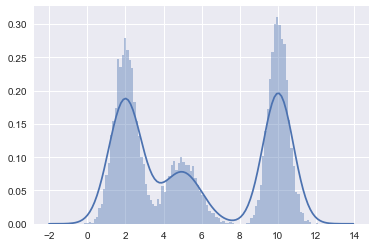

In [5]:
sns.distplot(x, bins=100);

## Supervised learning

In supervised learning, we have some training data of $N$ data points, each with $m$ features. The big idea is that on the training set, we have **a label associated with each data point**. Here the label is $z$.

For a feature vector x, we use Bayes rule to express the posterior of the class-conditional as:

$$p(z = c \vert x, \theta) = \frac{p(z = c  \vert  \theta)p(x  \vert  z = c, \theta)}{ \sum_{c′} p(z = c′  \vert  \theta) p(x  \vert  z = c′, \theta)}$$

This is a **generative classifier**, since it specifies how to generate the data using the class-conditional density $p(x \vert z = c, \theta)$ and the class prior $p(z = c\vert \theta)$. 

Notice that even though we are talking about priors and posteriors here, I am carrying along $\theta$. This is because the models here are just probabilistic models, and we havent chosen a frequentist or bayesian modelling paradigm yet. We are just specifying the model, and the priors and posteriors we are talking about  here are simply those from bayes theorem.

An alternative approach is to directly fit the class posterior, $p(z = c \vert x, \theta)$; this is known as a **discriminative classifier**. For example, a Gaussian Mixture model or Naive bayes is a generative classifier whose discriminative counterpart is the logistic regression.

**The supervised learning case is the one in which where hidden variables $z$ are known on the training set**. So the supervized case is one in which the model is not a hidden variables model at all.

### Gaussian Discriminant Analysis

Suppose we have input data 
$x$ that are continuous-valued random variables, and $z$ labels.  We call  $p(x,z \vert \theta)$ the **full-data likelihood**. Since we have both $z$ and $x$ on our training set, this is the likelihood we will want to maximize.

Let us see how to obtain it.

Our model is (limiting ourselves to two gaussians for simplicity):

$$ Z \sim \rm{Bernoulli}(\lambda) $$
$$ X \vert z=0 \sim {\cal N}(\mu_0, \Sigma_0) $$
$$ X \vert z=1 \sim {\cal N}(\mu_1, \Sigma_1) $$

The distributions in details are
$$ p(z) = \lambda^z (1-\lambda)^{1-z}$$
$$ p(x \vert z=0) = \frac{1}{(2\pi)^{n/2}  \vert  \Sigma \vert ^{1/2}} \exp \left( -\frac{1}{2}(x-\mu_0)^T \,\Sigma_0^{-1}(x-\mu_0) \right) $$
$$ p(x \vert z=1) = \frac{1}{(2\pi)^{n/2}  \vert  \Sigma \vert ^{1/2}} \exp \left( -\frac{1}{2}(x-\mu_1)^T \,\Sigma_1^{-1}(x-\mu_1) \right) $$


where the parameters of the model $\lambda$, $\Sigma_0$, $\Sigma_1$, $\mu_0$ and $\mu_1$ are to be determined. 
From here on, for simplicity of exposition we will use one covariance matrix for both Gaussians, $\Sigma$. This is called tieing the covariances and leads to a model in the literature called Linear Discriminant Analysis. 


The full-data log-likelihood of the data is given 

$$
\begin{eqnarray}
 l(x,z \vert  \lambda,\mu_0, \mu_1, \Sigma) &=& \log \prod_{i=1}^{m} p(x_i,z_i \vert  \lambda, \mu_0, \mu_1, \Sigma) \nonumber \\ 
          &=& \sum_{i=1}^{m} \log \left[p(x_i \vert z_i,  \mu_0, \mu_1, \Sigma) \,p(z_i \vert  \lambda) \right]  \nonumber \\ 
          &=& \sum_{i=1}^{m} \log p(x_i \vert z_i,  \mu_0, \mu_1, \Sigma) + \sum_{i=1}^{m}  \log p(z_i \vert  \lambda)   \nonumber   \\      
	&=&  -\sum_{i=1}^{m} \log ((2\pi)^{n/2}  \vert  \Sigma \vert ^{1/2}) - \frac{1}{2} \sum_{i=1}^{m}  (x-\mu_{z_i})^T \,\Sigma^{-1}(x-\mu_{z_i})   \nonumber \\ 
		& & \quad \quad +\sum_{i=1}^{m} \left[ z_i \, \log \lambda + (1-z_i) \log(1-\lambda) \right]
\end{eqnarray}
$$


Taking derivatives with respect to  $\lambda$, $\Sigma$, $\mu_0$ and $\mu_1$ and setting them to zero we get 

$$
\begin{eqnarray}
   \lambda & = &\frac{1}{m}  \sum_{i=1}^{m}  \delta_{z_i,1} \nonumber  \\ 
   \mu_0 &=& \frac{ \sum_{i=1}^{m}  \delta_{z_i,0} \, x_i  }{ \sum_{i=1}^{m}   \delta_{z_i,0}}\nonumber  \\ 
    \mu_1 &=& \frac{ \sum_{i=1}^{m}  \delta_{z_i,1} \, x_i  }{ \sum_{i=1}^{m}   \delta_{z_i,1}}\nonumber  \\ 
 \Sigma &=&\frac{1}{m}   \sum_{i=1}^{m}  (x_i-\mu_{z_i})   (x_i-\mu_{z_i})^{T} 
\end{eqnarray}
$$

This gives us the obvious result, namely $\lambda$ is nothing more but the fraction of objects with label $z=1$ and the total 
number of objects, $\mu$'s are the mean within the class and $\Sigma$ is the the covariance matrix 
for each group. This analysis is called "Gaussian Discriminant Analysis" or GDA, here specifically LDA as we tied the covariance matrices.

Lets do this in code. First we simulate some data:

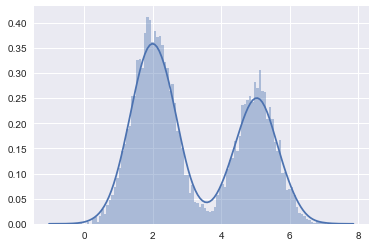

In [6]:
#In 1-D
# True parameter values
mu_true = np.array([2, 5])
sigma_true = np.array([0.6, 0.6])
lambda_true = np.array([.4, .6])
n = 10000

# Simulate from each distribution according to mixing proportion lambda_true
from scipy.stats import binom
z = binom.rvs(1, lambda_true[0], size=n)
x=np.array([np.random.normal(mu_true[i], sigma_true[i]) for i in z])
sns.distplot(x, bins=100);

Now we split into a training set and a test set.

In [8]:
#the z's are the classes in the supervised learning
#the 'feature' is the x position of the sample
from sklearn.model_selection import train_test_split
ztrain, ztest, xtrain, xtest = train_test_split(z,x)

In [9]:
ztrain.shape, xtrain.shape

((7500,), (7500,))

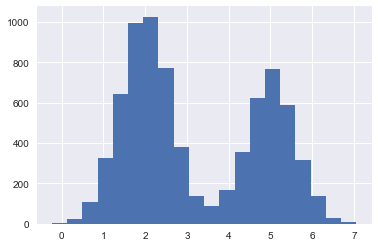

In [12]:
plt.hist(xtrain, bins=20);

In [13]:
lambda_train=np.mean(ztrain)
mu0_train = np.sum(xtrain[ztrain==0])/(np.sum(ztrain==0))
mu1_train = np.sum(xtrain[ztrain==1])/(np.sum(ztrain==1))
xmus=np.array([mu0_train if z==0 else mu1_train for z in ztrain])
xdiffs = xtrain - xmus
sigma_train=np.sqrt(np.dot(xdiffs, xdiffs)/xtrain.shape[0])
print(lambda_train, mu0_train, mu1_train, sigma_train)

0.407066666667 1.99814996529 5.0176232719 0.599407546657


We can use the log likelihood at a given `x` as a classifier: assign the class '0' or '1' depending upon which probability $p(x_j \vert \lambda, z, \Sigma)$ is larger. Note that this is JUST the $x$ likelihood, because we want to compare probabilities for fixed $z$s.

$$log\,p(x_j \vert \lambda, z, \Sigma) = -\sum_{i=1}^{m} \log ((2\pi)^{n/2}  \vert  \Sigma \vert ^{1/2}) - \frac{1}{2} \sum_{i=1}^{m}  (x-\mu_{z_i})^T \,\Sigma^{-1}(x-\mu_{z_i})  $$

The first term of the likelihood does not matter since it is independent of $z$, therefore:

In [14]:
def loglikdiff(x):
    for0= - (x-mu0_train)*(x-mu0_train)/(2.0*sigma_train*sigma_train) 
    for0 = for0 + np.log(1.-lambda_train)
    for1 = - (x-mu1_train)*(x-mu1_train)/(2.0*sigma_train*sigma_train) 
    for1 = for1 + np.log(lambda_train)
    return 1*(for1 - for0 >= 0)

In [15]:
pred = np.array([loglikdiff(test_x) for test_x in xtest])
print("correct classification rate", np.mean(ztest == pred))

correct classification rate 0.9944


## Unsupervised learning: Mixture of Gaussians 

In unsupervised learning, we do not know the class labels. We wish to generate these labels automatically from the data. An example of an unsupervised model is clustering.  In the context of mixture models we then do not know what the components of the mixture model are, i.e. what the parameters of the components and their admixture ($\lambda$s) are. Indeed, we might not even know how many components we have!!

In this case, to carry out the clustering, we first fit the mixture model, and then compute $p(z_i = k  \vert  x_i, \theta)$, which represents the posterior probability that point i belongs to cluster k. This is known as the responsibility of cluster k for point i, and can be computed as before using Bayes rule as follows:

$$p(z_k = c \vert x_i, \theta) = \frac{p(z_k = c  \vert  \theta)p(x_i  \vert  z_k = c, \theta)}
{ \sum_{_c′} p(z_k = c′  \vert  \theta) p(x_i  \vert  z_k = c′, \theta)}$$

This is called soft clustering. K-means is a hard-clustering analog where you associate a data point with a cluster rather than simply computing probabilities for the association.

The process is identical to the computations performed before in the supervised learning, except at training time: here we never observe $z_k$ for any samples, whereas before with the generative GDA classifier, we did observe $z_k$ on the training set.

How many clusters? The best number will generalize best to future data, something we can use cross-validation or other techniques to find.

Put differently, **unsupervised learning is a density estimation problem for $p(x)$**.

$$p(x) = \sum_c p(x \vert z) p(z).$$

In other words we discover the marginal p(x) through the generative model $p(x \vert z)$. This is also very useful in discovering **outliers** in our data.

### Concretely formulating the problem

So let us turn our attention to the case where we do not know the labels $z$. 

Suppose we are given a data set $\{x_1,\ldots, x_m\}$ but not given the labels $z$. The model consists of 
$k$ Gaussians. In other words our model assumes that each $x_i$ was generated by randomly choosing 
$z_i$ from $\{1, \ldots, k\}$, and then $x_i$ is drawn from one of the $k$ Gaussians depending on 
$z_i$. 

We wish to compute either the maximum likelihood estimate for this model, $p(\{x_{i}\} \vert \theta)$.
The goal is to model the joint distribution $p(\{x_i\}, \{z_i\})=p(\{x_i\} \vert \{z_i\}) \, p(\{z_i\})$ where $z_i \sim \rm{Categorical}(\lambda)$, and $\lambda = \{\lambda_j\}$.

As in our definition of mixture models $\lambda_j\ge0$  and 

$$ \sum_j^k \lambda_i = 1 $$

The parameters $\lambda_j$  produce $p(z_i=j)$ and then $x_i \vert z_i=j \sim {\cal N}(\mu_j, \Sigma_j)$.

The parameters of our problem are $\lambda$, $\mu$ and $\Sigma$. But because the labels $z$ are hidden to us, we no longer have the full-data likelihood. So we estimate our parameters by minimizing the $x$-data log-likelihood:

$$
\begin{eqnarray}
l(x \vert  \lambda, \mu, \Sigma) &=& \sum_{i=1}^{m} \log p(x_i \vert  \lambda,  \mu ,\Sigma)   \nonumber \\ 
     &=& \sum_{i=1}^{m} \log \sum_z p(x_i \vert  z_i,  \mu , \Sigma) \, p(z_i \vert  \lambda)  
\end{eqnarray}
$$

However, if we set to zero the derivatives of this formula with respect to
the parameters and try to solve, we'll find that it is not possible to find the
maximum likelihood estimates Futhermore, we have to enforce constraints such as mixing weights summing to 1, covariance matrices being positive definite, etc. 

For all of these reasons, its simpler, but not always faster to use an iterative algorithm called the EM algorithm to get the local maximum likelihood or MAP estimate. We shall learn this algorithm soon. But we can also set this problem up as a bayesian problem with reasonable priors on the parameters and try to use MCMC.

## Semi-supervised

In unsupervized learning we are given samples from some unknown data distribution with density $p(x)$. Our goal is to estimate this density or a known functional  (like the risk) thereof. Supervized learning can be treated as estimating $p(x,c)$ or a known functional of it. But there is usually no need to estimate the input distribution so estimating the complete density is wasteful, and we usually focus on estimating $p(c \vert x)$ discriminatively or generatively(via $p(x \vert c) p(c)$. Here $c$ or $y$ or $z$ are the classes we are trying to estimate. In the unsupervized case we often estimate $\sum_z p(x \vert z) p(z) = p(x)$ with latent (hidden) $z$, which you may or may not wish to identify with classes.

Semi-supervised learning is the situation in which we have some labels, but typically very few labels: not enough to form a good training set.

In semi-supervized learning we combine the two worlds. We write a joint likelihood for the supervised and unsupervised parts:

$$ l(\{x_i\},\{x_j\},\{z_i\} \vert \theta, \lambda) = \sum_i log \, p(x_i, z_i \vert \lambda, \theta) +  \sum_j log \, p(x_j \vert \lambda, \theta) = \sum_i log \, p(z_i \vert \lambda) p(x_i \vert z_,\theta) + \sum_j log \, \sum_z p(z_j \vert \lambda) p(x_j \vert z_j,\theta) $$

Here $i$ ranges over the data points where we have labels, and $j$ over the data points where we dont.

In a traditional classification-based machine learning scenario we might still split the data into a training and validation set. But the basic idea in semi-supervised learning is that there is structure in $p(x)$ which might help us divine the conditionals, so what we would want to do, is include in the training set unlabelled points. The game then is that if there is geometric structure in $p(x)$, some kind of cluster based foliation, then we can explot this.